# Structured data classification

This tutorial is mainly based on the Keras tutorial ["Structured data classification from scratch"](https://keras.io/examples/structured_data/structured_data_classification_from_scratch/) by François Chollet.

## Setup

In [67]:
import tensorflow as tf
import numpy as np
import pandas as pd
from tensorflow import keras
from tensorflow.keras import layers

## Data


Here's the description of each feature:

Column| Description| Feature Type
------------|--------------------|----------------------
Age | Age in years | Numerical
Sex | (1 = male; 0 = female) | Categorical
CP | Chest pain type (0, 1, 2, 3, 4) | Categorical
Trestbpd | Resting blood pressure (in mm Hg on admission) | Numerical
Chol | Serum cholesterol in mg/dl | Numerical
FBS | fasting blood sugar in 120 mg/dl (1 = true; 0 = false) | Categorical
RestECG | Resting electrocardiogram results (0, 1, 2) | Categorical
Thalach | Maximum heart rate achieved | Numerical
Exang | Exercise induced angina (1 = yes; 0 = no) | Categorical
Oldpeak | ST depression induced by exercise relative to rest | Numerical
Slope | Slope of the peak exercise ST segment | Numerical
CA | Number of major vessels (0-3) colored by fluoroscopy | Both numerical & categorical
Thal | normal; fixed defect; reversible defect | Categorical (string)
Target | Diagnosis of heart disease (1 = true; 0 = false) | Target

### Data import
Let's download the data and load it into a Pandas dataframe:

In [68]:
file_url = "http://storage.googleapis.com/download.tensorflow.org/data/heart.csv"
df = pd.read_csv(file_url)

In [69]:
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,1,145,233,1,2,150,0,2.3,3,0,fixed,0
1,67,1,4,160,286,0,2,108,1,1.5,2,3,normal,1
2,67,1,4,120,229,0,2,129,1,2.6,2,2,reversible,0
3,37,1,3,130,250,0,0,187,0,3.5,3,0,normal,0
4,41,0,2,130,204,0,2,172,0,1.4,1,0,normal,0


In [70]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    int64  
 1   sex       303 non-null    int64  
 2   cp        303 non-null    int64  
 3   trestbps  303 non-null    int64  
 4   chol      303 non-null    int64  
 5   fbs       303 non-null    int64  
 6   restecg   303 non-null    int64  
 7   thalach   303 non-null    int64  
 8   exang     303 non-null    int64  
 9   oldpeak   303 non-null    float64
 10  slope     303 non-null    int64  
 11  ca        303 non-null    int64  
 12  thal      303 non-null    object 
 13  target    303 non-null    int64  
dtypes: float64(1), int64(12), object(1)
memory usage: 33.3+ KB


The following features are *categorical features* encoded as integers:

- `sex`
- `cp`
- `fbs`
- `restecg`
- `exang`
- `ca`

The following feature is a *categorical features* encoded as string:

- `thal`

### Data structure

In [71]:
# Convert to string
df['thal'] = df['thal'].astype("string")

In [72]:
# Convert to categorical
cat_convert = ['sex', 'cp', 'fbs', 'restecg', 'exang', 'ca']

for i in cat_convert:
    df[i] = df[i].astype("category")

In [73]:
# define outcome variable as y_label
y_label = 'target'

# Make list of all numerical data (except label)
list_num = df.drop(columns=[y_label]).select_dtypes(include=[np.number]).columns.tolist()

# Make list of all categorical data (except label)
list_cat = df.drop(columns=[y_label]).select_dtypes(include=['category']).columns.tolist()

### Data splitting

Let's split the data into a training and validation set:

In [74]:
val_dataframe = df.sample(frac=0.2, random_state=1337)
train_dataframe = df.drop(val_dataframe.index)

print(
    "Using %d samples for training and %d for validation"
    % (len(train_dataframe), len(val_dataframe))
)

Using 242 samples for training and 61 for validation


### Transform to Tensors

- Let's generate [`tf.data.Dataset`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset) objects for our training and validation dataframes:

In [75]:
# Define a function to create our tensors

def dataframe_to_dataset(dataframe):
    dataframe = df.copy()
    labels = dataframe.pop(y_label)
    ds = tf.data.Dataset.from_tensor_slices((dict(dataframe), labels))
    ds = ds.shuffle(buffer_size=len(dataframe))
    return ds

In [76]:
# Use function
train_ds = dataframe_to_dataset(train_dataframe)
val_ds = dataframe_to_dataset(val_dataframe)

- Let's batch the datasets (combine some of our samples). Here, we use a mini-batch size of 32:

In [77]:
train_ds = train_ds.batch(32)
val_ds = val_ds.batch(32)

In [78]:
train_ds

<BatchDataset shapes: ({age: (None,), sex: (None,), cp: (None,), trestbps: (None,), chol: (None,), fbs: (None,), restecg: (None,), thalach: (None,), exang: (None,), oldpeak: (None,), slope: (None,), ca: (None,), thal: (None,)}, (None,)), types: ({age: tf.int64, sex: tf.int64, cp: tf.int64, trestbps: tf.int64, chol: tf.int64, fbs: tf.int64, restecg: tf.int64, thalach: tf.int64, exang: tf.int64, oldpeak: tf.float64, slope: tf.int64, ca: tf.int64, thal: tf.string}, tf.int64)>

## Feature preprocessing


### Preprocessing functions

- Below, we define utility functions to do the feature preprocessing operations:

- For each numeric feature in the dataset, you will use a tf.keras.layers.Normalization layer to standardize the distribution of the data.

- Define a new utility function that returns a layer which applies feature-wise normalization to numerical features using that Keras preprocessing layer:

In [79]:
# Define numerical preprocessing function
def get_normalization_layer(name, dataset):
    # Create a Normalization layer for our feature
    normalizer = layers.Normalization(axis=None)

    # Prepare a Dataset that only yields our feature
    feature_ds = dataset.map(lambda x, y: x[name])

    # Learn the statistics of the data
    normalizer.adapt(feature_ds)

    # Normalize the input feature
    return normalizer

- Categorical data preprocessing

In [80]:
from tensorflow.keras.layers import IntegerLookup
from tensorflow.keras.layers import StringLookup

# Define categorical preprocessing function
def encode_categorical_feature(feature, name, dataset, is_string):
    lookup_class = StringLookup if is_string else IntegerLookup
    # Create a lookup layer which will turn strings into integer indices
    lookup = lookup_class(output_mode="binary")

    # Prepare a Dataset that only yields our feature
    feature_ds = dataset.map(lambda x, y: x[name])
    feature_ds = feature_ds.map(lambda x: tf.expand_dims(x, -1))

    # Learn the set of possible string values and assign them a fixed integer index
    lookup.adapt(feature_ds)

    # Turn the string input into integer indices
    encoded_feature = lookup(feature)
    return encoded_feature


Define another new utility function that returns a layer which maps values from a vocabulary to integer indices and multi-hot encodes the features using the tf.keras.layers.StringLookup, tf.keras.layers.IntegerLookup, and tf.keras.CategoryEncoding preprocessing layers:




In [81]:
def get_category_encoding_layer(name, dataset, dtype, max_tokens=None):
  # Create a layer that turns strings into integer indices.
  if dtype == 'string':
    index = layers.StringLookup(max_tokens=max_tokens)
  # Otherwise, create a layer that turns integer values into integer indices.
  else:
    index = layers.IntegerLookup(max_tokens=max_tokens)

  # Prepare a `tf.data.Dataset` that only yields the feature.
  feature_ds = dataset.map(lambda x, y: x[name])

  # Learn the set of possible values and assign them a fixed integer index.
  index.adapt(feature_ds)

  # Encode the integer indices.
  encoder = layers.CategoryEncoding(num_tokens=index.vocabulary_size())

  # Apply multi-hot encoding to the indices. The lambda function captures the
  # layer, so you can use them, or include them in the Keras Functional model later.
  return lambda feature: encoder(index(feature))

With this done, we can create our preprocessing steps:

- Normalize the numerical features and add them to one list of inputs called `encoded_features`:

In [82]:
all_inputs = []
encoded_features = []

# Numerical features.
for feature in list_num:
  numeric_col = keras.Input(shape=(1,), name=feature)
  normalization_layer = get_normalization_layer(feature, train_ds)
  encoded_numeric_col = normalization_layer(numeric_col)
  all_inputs.append(numeric_col)
  encoded_features.append(encoded_numeric_col)

In [83]:
encoded_features

[<KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'normalization_28')>,
 <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'normalization_29')>,
 <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'normalization_30')>,
 <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'normalization_31')>,
 <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'normalization_32')>,
 <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'normalization_33')>]

- Make a list of all encoded features

In [84]:
all_features = layers.concatenate(encoded_features)

- Note that we also could use a for loop to automate some of the steps above:

In [85]:
## Model

Now we can build the model: 

1. We use 32 number of units in the first layer
1. We use [layers.Dropout()](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dropout) to prevent overvitting
1. Our output layer has 1 output (since the classification task is binary)
1. keras.Model groups layers into an object with training and inference features.


In [86]:
# First layer
x = layers.Dense(32, activation="relu")(all_features)
# Dropout to prevent overvitting
x = layers.Dropout(0.5)(x)
# Output layer
output = layers.Dense(1, activation="sigmoid")(x)

# Group all layers 
model = keras.Model(all_inputs, output)

In [87]:
model.compile(optimizer="adam", 
              loss ="binary_crossentropy", 
              metrics=["accuracy"])

Let's visualize our connectivity graph:

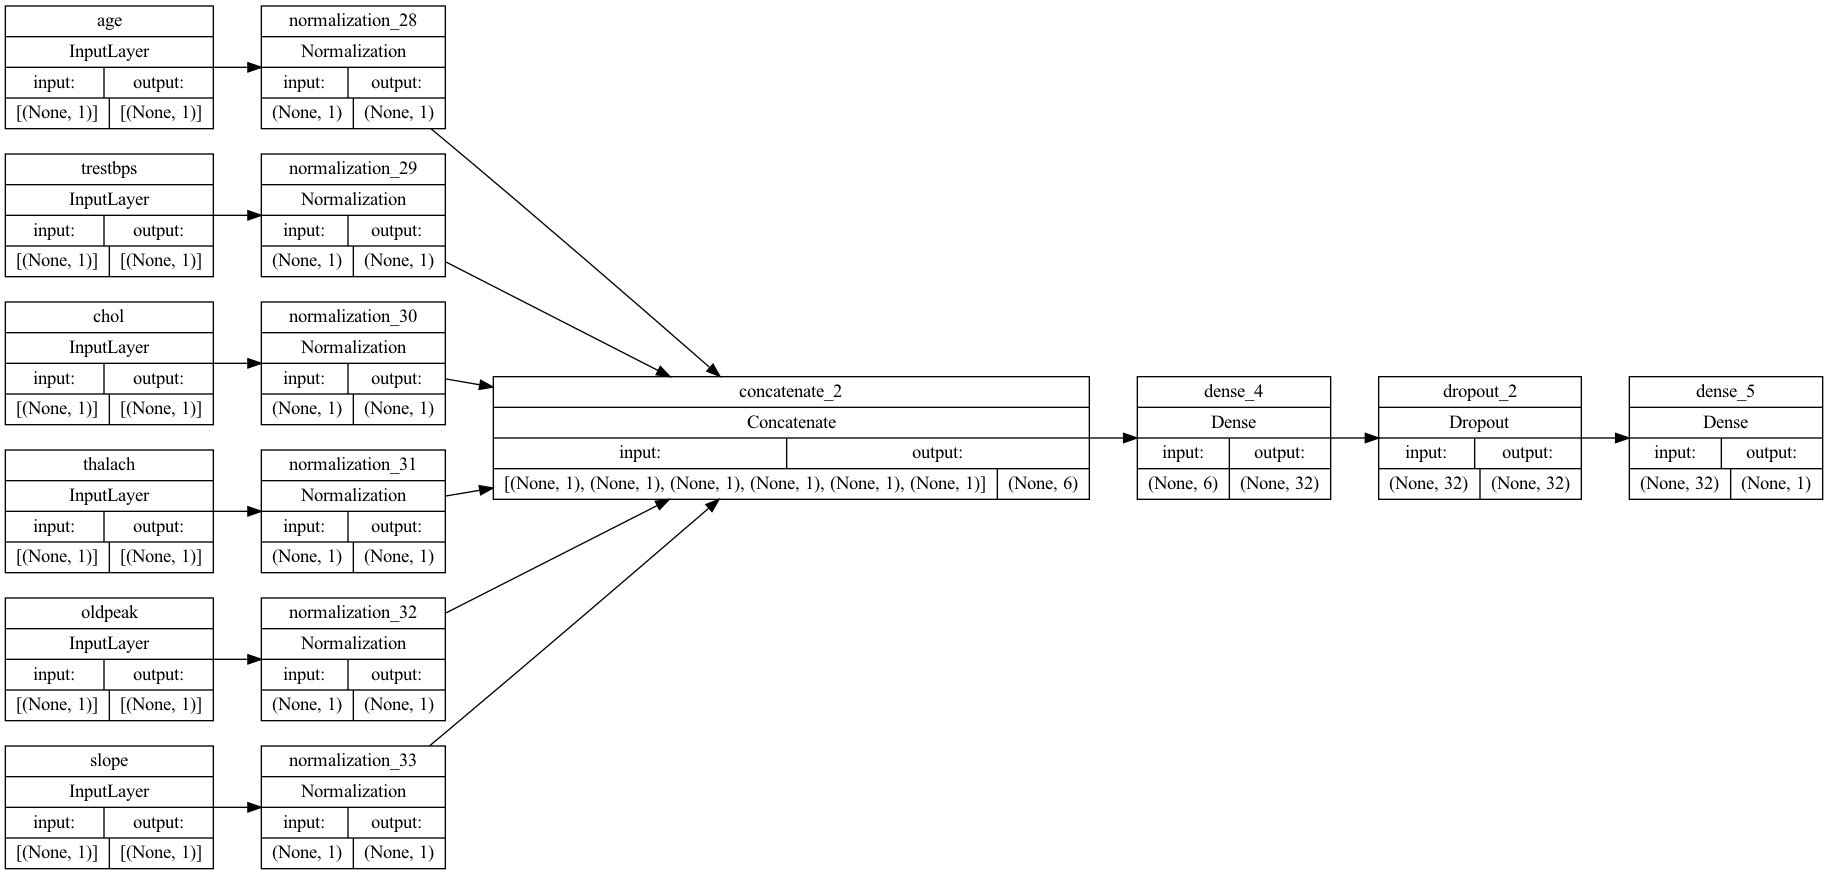

In [88]:
# `rankdir='LR'` is to make the graph horizontal.
keras.utils.plot_model(model, show_shapes=True, rankdir="LR")

## Training

In [89]:
model.fit(train_ds, epochs=10, validation_data=val_ds)

Epoch 1/10


/Users/jankirenz/opt/anaconda3/envs/tf/lib/python3.8/site-packages/keras/engine/functional.py:559: UserWarning: Input dict contained keys ['sex', 'cp', 'fbs', 'restecg', 'exang', 'ca', 'thal'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


10/10 [==============================] - 0s 14ms/step - loss: 0.7481 - accuracy: 0.5083 - val_loss: 0.6906 - val_accuracy: 0.5941
Epoch 2/10
10/10 [==============================] - 0s 4ms/step - loss: 0.7339 - accuracy: 0.5413 - val_loss: 0.6576 - val_accuracy: 0.6271
Epoch 3/10
10/10 [==============================] - 0s 4ms/step - loss: 0.6958 - accuracy: 0.5776 - val_loss: 0.6286 - val_accuracy: 0.6535
Epoch 4/10
10/10 [==============================] - 0s 4ms/step - loss: 0.6554 - accuracy: 0.5908 - val_loss: 0.6037 - val_accuracy: 0.6700
Epoch 5/10
10/10 [==============================] - 0s 4ms/step - loss: 0.6460 - accuracy: 0.6106 - val_loss: 0.5814 - val_accuracy: 0.6931
Epoch 6/10
10/10 [==============================] - 0s 4ms/step - loss: 0.5947 - accuracy: 0.6634 - val_loss: 0.5617 - val_accuracy: 0.7096
Epoch 7/10
10/10 [==============================] - 0s 4ms/step - loss: 0.5911 - accuracy: 0.6733 - val_loss: 0.5439 - val_accuracy: 0.7195
Epoch 8/10
10/10 [============

## Predictions

In [90]:
sample = {
    "age": 60,
    "sex": 1,
    "cp": 1,
    "trestbps": 145,
    "chol": 233,
    "fbs": 1,
    "restecg": 2,
    "thalach": 150,
    "exang": 0,
    "oldpeak": 2.3,
    "slope": 3,
    "ca": 0,
    "thal": "fixed",
}

input_dict = {name: tf.convert_to_tensor([value]) for name, value in sample.items()}

predictions = model.predict(input_dict)

print(
    "This particular patient had a %.1f percent probability "
    "of having a heart disease, as evaluated by our model." % (100 * predictions[0][0],)
)

This particular patient had a 61.8 percent probability of having a heart disease, as evaluated by our model.
